# Compare the single cell data with metagenomic data processing


## Metagenomic data processing

metagenomic raw data saved in file: 
/drive1/xiangpeng/Project/bacteria/HM3/RawReads/
HuEf_HM3_repA_S112_R1_001.fastq.gz
HuEf_HM3_repA_S112_R2_001.fastq.gz
HuEf_HM3_repB_S124_R1_001.fastq.gz
HuEf_HM3_repB_S124_R2_001.fastq.gz
HuEf_HM3_repC_S136_R1_001.fastq.gz
HuEf_HM3_repC_S136_R2_001.fastq.gz


output folder: /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/meta_vs_psudobulk/meta/

Use kraken to profile the sample (GTDB database)


### metagenomic sample kraken processing (GTDB)

for sample in `ls /drive1/xiangpeng/Project/bacteria/HM3/RawReads/*_R1_001.fastq.gz`; do dir="/drive1/xiangpeng/Project/bacteria/HM3/"; base=$(basename $sample "_R1_001.fastq.gz"); kraken2  --threads 32 --memory-mapping  --db /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/  --report ${dir}/kraken/${base}_gtdb.kraken  --output ${dir}/kraken/${base}_gtdb.output --paired  ${dir}/RawReads/${base}_R1_001.fastq.gz  ${dir}/RawReads/${base}_R2_001.fastq.gz; done

ls *.kraken | parallel 'bracken -d bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/bracken/  -l G -i {} -o {.}_G.bracken'

### psudo bulk kraken analysis (gtdb)
/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/
kraken2  --threads 12 --memory-mapping  --db /drive1/xiangpeng/reference/kraken2/GTDB_release95/kraken/  --report hm3_gtdb.kraken  --output hm3_gtdb.output --paired  human_R1.fastq.gz human_R2.fastq.gz

ls *.kraken | parallel 'bracken -d /drive1/xiangpeng/reference/kraken2/GTDB_release95/bracken/ -l G -i {} -o {.}_G.bracken'


### Move the output 

mv /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/hm3*  /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/meta_vs_psudobulk/psudobulk

mv  /drive1/xiangpeng/Project/bacteria/HM3/kraken/* /drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/meta_vs_psudobulk/meta

In [1]:
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns
import os
import math
from matplotlib.colors import LogNorm, Normalize

In [2]:
## group the kraken/bracken output
meta_g_file = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/meta_vs_psudobulk/meta/HuEf_HM3_repA_S112_gtdb_G.bracken'
psudo_g_file = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/meta_vs_psudobulk/psudobulk/hm3_gtdb_G.bracken'

g_files = [meta_g_file, psudo_g_file]
file_names = ['meta', 'psudo_bulk']
save_dir = '/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/meta_vs_psudobulk/'



In [3]:
drop_lst = ['name', 'taxonomy_lvl','kraken_assigned_reads','added_reads', 'new_est_reads']
meta_G = pd.read_csv(meta_g_file, sep = '\t')
meta_G['name']=meta_G['name'].str.replace('g__', '')
meta_G = meta_G.set_index('name')
meta_G = meta_G[meta_G['fraction_total_reads']!=0]
meta_G.head(10)

,taxonomy_id,taxonomy_lvl,kraken_assigned_reads,added_reads,new_est_reads,fraction_total_reads
name,,,,,,
Phocaeicola,122573,G,3965708,608734,4574442,0.18863
Bacteroides,120406,G,2634089,298135,2932224,0.12091
Prevotella,134172,G,43891,1578,45469,0.00187
Paraprevotella,171621,G,31292,2535,33827,0.00139
Prevotellamassilia,164199,G,8749,451,9200,0.00038
F0040,198199,G,1597,28,1625,0.00007
CAG-617,187804,G,1555,57,1612,0.00007
Alloprevotella,184157,G,1256,117,1373,0.00006
UBA4372,155534,G,1009,7,1016,0.00004


array([[<AxesSubplot:title={'center':'fraction_total_reads'}>]],
      dtype=object)

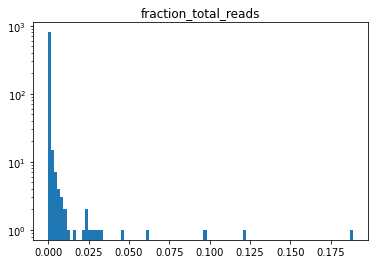

In [4]:
meta_G.hist(column = 'fraction_total_reads', bins = 100, grid = False, log = True)

In [5]:
# metagenomic data
meta_G = pd.read_csv(meta_g_file, sep = '\t') # read the bracken output data
meta_G['name']=meta_G['name'].str.replace('g__', '') # remove the string 'g__' before the Genus name
meta_G = meta_G.set_index('name')  # set genus name as the index
meta_G = meta_G[meta_G['fraction_total_reads']!=0] # remove the genus with 0 read fraction. 
meta_G.head()

,taxonomy_id,taxonomy_lvl,kraken_assigned_reads,added_reads,new_est_reads,fraction_total_reads
name,,,,,,
Phocaeicola,122573,G,3965708,608734,4574442,0.18863
Bacteroides,120406,G,2634089,298135,2932224,0.12091
Prevotella,134172,G,43891,1578,45469,0.00187
Paraprevotella,171621,G,31292,2535,33827,0.00139
Prevotellamassilia,164199,G,8749,451,9200,0.00038


In [6]:
# psudo bulk data
psudo_G = pd.read_csv(psudo_g_file, sep = '\t') # read the bracken output data
psudo_G['name']=psudo_G['name'].str.replace('g__', '')# remove the string 'g__' before the Genus name
psudo_G = psudo_G.set_index('name')# set genus name as the index
psudo_G = psudo_G[psudo_G['fraction_total_reads']!=0]# remove the genus with 0 read fraction. 
psudo_G.head()

,taxonomy_id,taxonomy_lvl,kraken_assigned_reads,added_reads,new_est_reads,fraction_total_reads
name,,,,,,
Blautia_A,135456,G,64331545,10696772,75028317,0.37491
Anaerobutyricum,147530,G,8775182,1845979,10621161,0.05307
Anaerostipes,140448,G,2586764,202252,2789016,0.01394
Ruminococcus_A,148107,G,2375389,237367,2612756,0.01306
Roseburia,146614,G,1328421,391225,1719646,0.00859


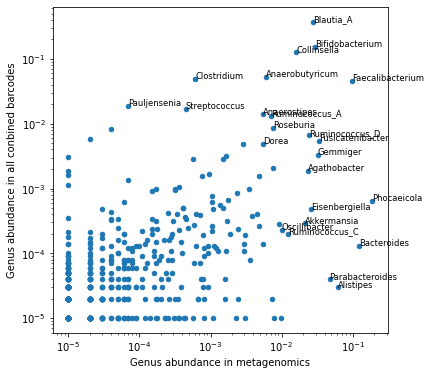

In [7]:
#combine 
combined_G = pd.concat([meta_G['fraction_total_reads'],psudo_G['fraction_total_reads']],axis =1, keys=['meta','psudo_bulk'])

# define data for annotation. 
min_percent =  0.01
above_1percent_G = combined_G[(combined_G['meta']>=min_percent) | (combined_G['psudo_bulk']>=min_percent) |(combined_G['psudo_bulk']+combined_G['meta']>=min_percent)]
# Scatter plot of the metagenomic data vs the psudobulk data at Family level
ax = combined_G.plot.scatter(x = 'meta', y = 'psudo_bulk', figsize=(6, 6))
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Genus abundance in metagenomics', )
plt.ylabel('Genus abundance in all conbined barcodes', )

# Annotate each data point 
for i, txt in enumerate(above_1percent_G.index.to_series()):
    ax.annotate(txt, (combined_G.meta.at[txt], combined_G.psudo_bulk.at[txt]), fontsize = 'small')
    
plt.savefig(save_dir+ 'psudo_bulk_metagenome.pdf', bbox_inches='tight')

In [15]:
# single cell barcode count data saved in file:
pure_bar_gns=pd.read_csv('/drive4/xiangpeng/Project/bacteria/novoseq/splited/human/scFASTQ/analysis/HM3_purity_filtered_genus_matrix.csv')
pure_bar_gns['Genus'] = pure_bar_gns['Genus'].str.replace('g__', '')
pure_bar_gns['counts'] = 1


In [24]:
# calculate the barcode count of each genus
single_G = pure_bar_gns.groupby(by=['Genus'])['counts'].sum().reset_index()
single_G = single_G.set_index('Genus') 

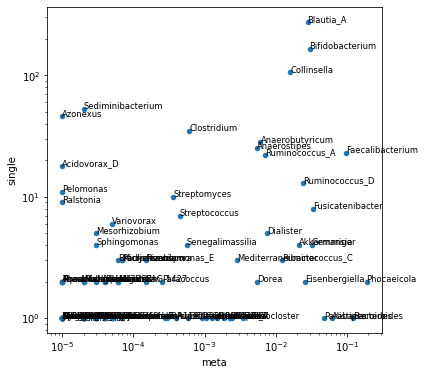

In [25]:
# single vs meta

#combine 
meta_vs_single_G = pd.concat([meta_G['fraction_total_reads'],single_G['counts']],axis =1, keys=['meta','single'])
meta_vs_single_G.fillna(0)

# Scatter plot of the metagenomic data vs the psudobulk data at Family level
ax = meta_vs_single_G.plot.scatter(x = 'meta', y = 'single', figsize=(6, 6))
ax.set_yscale('log')
ax.set_xscale('log')
# Annotate each data point 
for i, txt in enumerate(single_G.index.to_series()):
    ax.annotate(txt, (meta_vs_single_G.meta.at[txt], meta_vs_single_G.single.at[txt]), fontsize = 'small')

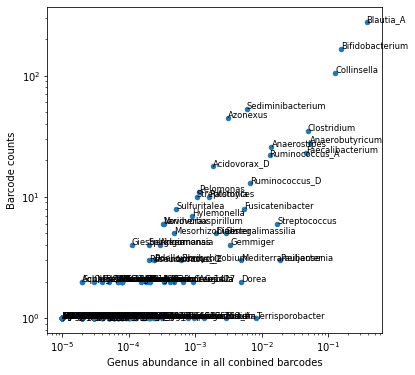

In [7]:
# single vs psudo_bulk



#combine 
psudo_vs_single_G = pd.concat([psudo_G['fraction_total_reads'],single_G['counts']],axis =1, keys=['psudo_bulk','single'])
psudo_vs_single_G.fillna(0)

# Scatter plot of the metagenomic data vs the psudobulk data at Family level

ax = psudo_vs_single_G.plot.scatter(x = 'psudo_bulk', y = 'single',figsize=(6, 6))
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Genus abundance in all conbined barcodes', )
plt.ylabel('Barcode counts',)
# Annotate each data point 
for i, txt in enumerate(single_G.index.to_series()):
    ax.annotate(txt, (psudo_vs_single_G.psudo_bulk.at[txt], psudo_vs_single_G.single.at[txt]), fontsize = 'small')

plt.savefig(save_dir+ 'barcodes_vs_psudo_bulk.pdf', bbox_inches='tight')


In [ ]:
cluster_df=pd.read_csv('/drive1/xiangpeng/Project/bacteria/HM3/assembly/splitted/analysis/hm3_contigs_singlecell_cluster_df.csv', index_col =0)
#cluster_df['cell_type_3']=cluster_df['cell_type_2'].str.replace('g__', '')
cluster_sc_group_df = cluster_df[cluster_df['batch']=='single_cell'].groupby(['cell_type_3']).size().reset_index().rename(columns={0:'counts'})
cluster_sc_group_df= cluster_sc_group_df.set_index('cell_type_3')
cluster_sc_cnt_dict = cluster_sc_group_df['counts'].to_dict()
cluster_sc_cnt_dict = {k: v for k, v in sorted(cluster_sc_cnt_dict.items(), key=lambda item: item[1], reverse=True)}
cluster_sc_ls = list(cluster_sc_cnt_dict.keys())

cluster_cnt_dict = cluster_df['cell_type_3'].value_counts()
cluster_cnt_dict = {k: v for k, v in sorted(cluster_cnt_dict.items(), key=lambda item: item[1], reverse=True)}
cluster_full_ls = list(cluster_cnt_dict.keys())

In [8]:
## make a custome palette contains 500 distict colors using glasbey.py
### https://github.com/taketwo/glasbey/tree/master
#### the color is saved in file ('/drive1/xiangpeng/apps/glasbey/color_set1_500.txt')
set1_500_colors = pd.read_csv('/drive1/xiangpeng/apps/glasbey/color_set1_500.txt', names = ['color'])['color'].tolist()
cluster_color_dict = dict(zip(cluster_full_ls, set1_500_colors[0:0+len(cluster_full_ls)]))
#cluster_color_dict

In [9]:
#combine 
combined_all_G = pd.concat([meta_G['fraction_total_reads'],psudo_G['fraction_total_reads'],single_G['counts']],axis =1, keys=['meta','psudo_bulk','single'])
combined_all_G = combined_all_G.fillna(0)

In [10]:
combined_all_G.head()

,meta,psudo_bulk,single
Phocaeicola,0.18863,0.00065,2.0
Bacteroides,0.12091,0.00013,1.0
Prevotella,0.00187,0.00020,1.0
Paraprevotella,0.00139,0.00000,0.0
Prevotellamassilia,0.00038,0.00003,0.0


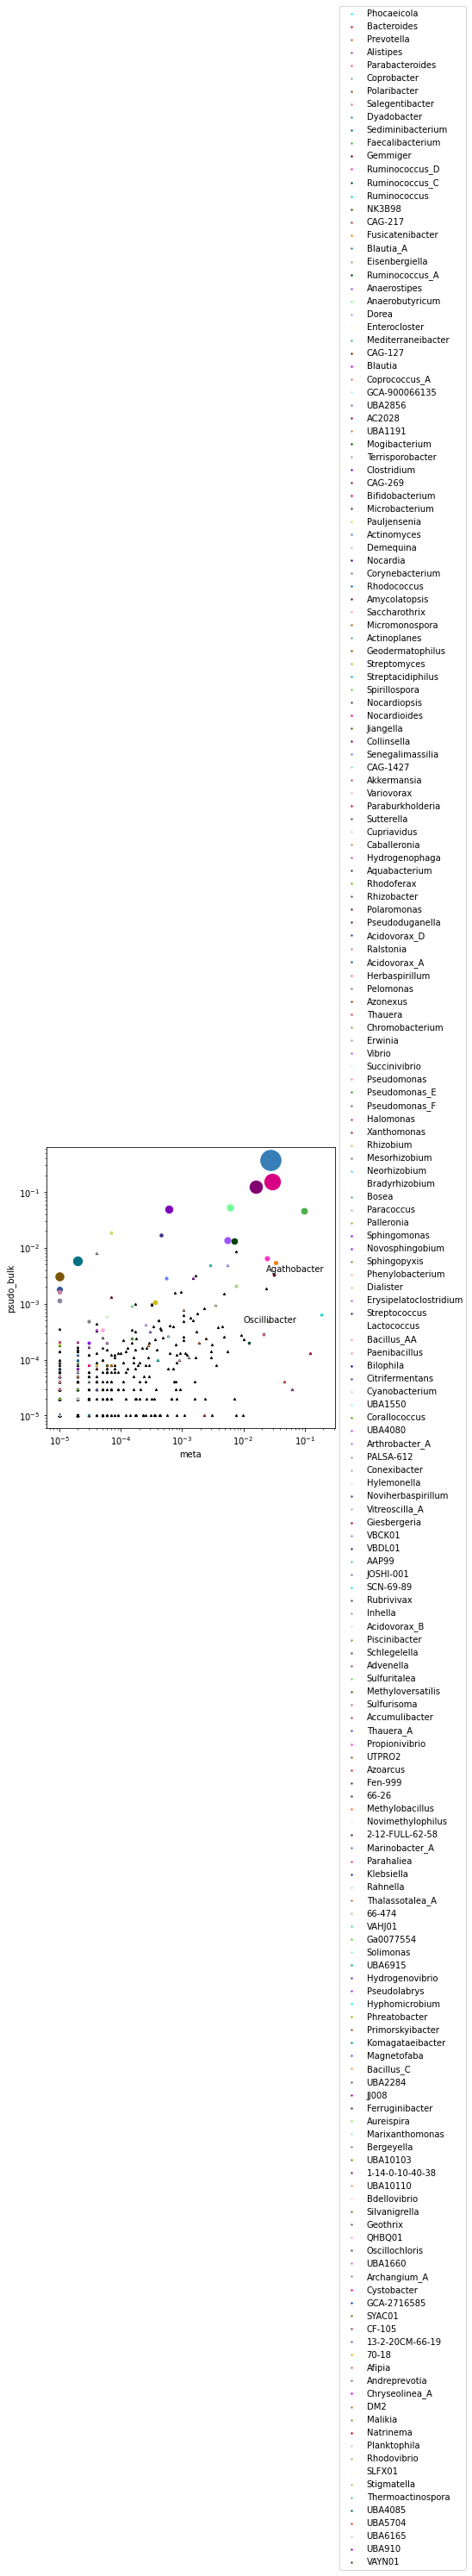

In [11]:
# Scatter plot of the metagenomic data vs the psudobulk data at Family level
ax = combined_G.plot.scatter(x = 'meta', y = 'psudo_bulk', figsize=(6, 6), c ='k', s= 5, marker = '^')
ax.set_yscale('log')
ax.set_xscale('log')
# add single cell data 
for i, txt in enumerate(combined_all_G[combined_all_G['single']>0].index.to_series()):
    #ax.annotate(txt, (combined_all_G.meta.at[txt], combined_all_G.psudo_bulk.at[txt]))
    ax.scatter(x = combined_all_G.meta.at[txt], y=combined_all_G.psudo_bulk.at[txt], s = combined_all_G.single.at[txt]*2, label = txt, c = cluster_color_dict[txt])
# annotate the data with 0.01 abundance in metagenome
for i, txt in enumerate(combined_all_G[(combined_all_G['meta']>=0.01)&(combined_all_G['single']==0)].index.to_series()):
    ax.annotate(txt, (combined_all_G.meta.at[txt], combined_all_G.psudo_bulk.at[txt]*2))

lgnd = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for handle in lgnd.legendHandles:
    handle.set_sizes([2])
#plt.savefig(save_dir+ 'meta_psudo_bulk_sizes1.svg', bbox_inches='tight')
plt.savefig(save_dir+ 'meta_psudo_bulk_sized_1.pdf', bbox_inches='tight')

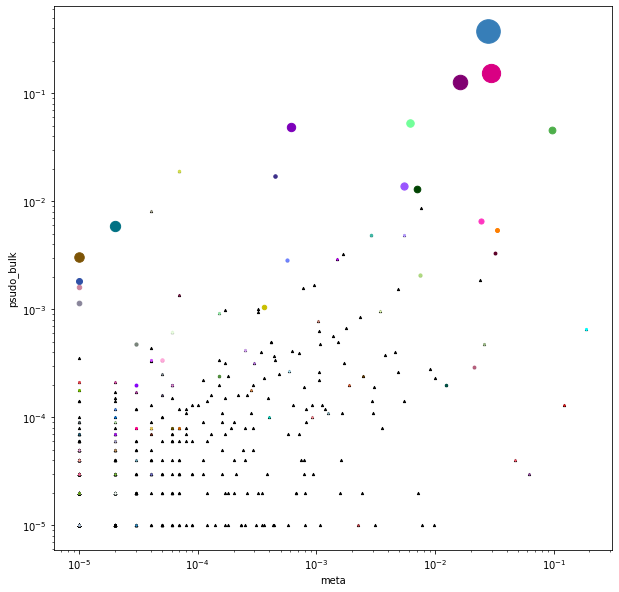

In [13]:
# Scatter plot of the metagenomic data vs the psudobulk data at Family level
ax = combined_G.plot.scatter(x = 'meta', y = 'psudo_bulk', figsize=(10, 10), c ='k', s= 5, marker = '^')
ax.set_yscale('log')
ax.set_xscale('log')
# add single cell data 
for i, txt in enumerate(combined_all_G[combined_all_G['single']>0].index.to_series()):
    #ax.annotate(txt, (combined_all_G.meta.at[txt], combined_all_G.psudo_bulk.at[txt]))
    ax.scatter(x = combined_all_G.meta.at[txt], y=combined_all_G.psudo_bulk.at[txt], s = combined_all_G.single.at[txt]*2, label = txt, c = cluster_color_dict[txt])

plt.savefig(save_dir+ 'meta_psudo_bulk_no_labels.pdf', bbox_inches='tight')

In [14]:
for i, txt in enumerate(combined_all_G[(combined_all_G['meta']>=0.005)|(combined_all_G['single']>=5)].index.to_series()):
    print(txt)
    

Phocaeicola
Bacteroides
Alistipes
Parabacteroides
Barnesiella
Sediminibacterium
Faecalibacterium
Gemmiger
Ruminococcus_D
Ruminococcus_C
Oscillibacter
ER4
Clostridium_A
Fusicatenibacter
Blautia_A
Eisenbergiella
Agathobacter
Acetatifactor
Ruminococcus_A
Roseburia
Eubacterium_F
Anaerostipes
Anaerobutyricum
Dorea
Clostridium
Bifidobacterium
Streptomyces
Collinsella
Senegalimassilia
Akkermansia
Parasutterella
Variovorax
Acidovorax_D
Ralstonia
Pelomonas
Azonexus
Mesorhizobium
Dialister
Streptococcus
Hylemonella
Noviherbaspirillum
Sulfuritalea
